
```js
{
    "a": -13.5,
    "dr": -1,
    "v": 0.4,
    "t": -0.2
}
```
a: angle between host and luggage
    angle in degree
    front is 0
    right is positive
dr: distance (relative) between host and luggage
    +1 is getting closer
    0 if distance constant
    -1 if distance getting shorter
d:
    distance between host and luggage

v: velocity of host?
t: direction of the host from the 

Angle in radian
Distance from 0.0 to 1.0 - keep at 0.5

the robot shouldnt move if within 1.5m distance - human can grab it

make reid work?
make simulation to always get the front line of the robot as if following the person at x speed
get north and acceleration

I receive the north to create the map

In [1]:
print('test')

test


In [2]:
names = {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted plant', 59: 'bed', 60: 'dining table', 61: 'toilet', 62: 'tv', 63: 'laptop', 64: 'mouse', 65: 'remote', 66: 'keyboard', 67: 'cell phone', 68: 'microwave', 69: 'oven', 70: 'toaster', 71: 'sink', 72: 'refrigerator', 73: 'book', 74: 'clock', 75: 'vase', 76: 'scissors', 77: 'teddy bear', 78: 'hair drier', 79: 'toothbrush'}

# camera settings
# hfov = 67.0
# wr = 1280

hfov = 59
wr = 1080
hr = 720
avg_shoulder_width = 350.0
avg_torso_height = 460.0


In [3]:
from dataclasses import dataclass
from IPython.display import clear_output

import matplotlib.pyplot as plt
import matplotlib.patches as patches

import numpy as np
import pandas as pd
import cv2
import math
import time
import os
import queue

import torch
from ultralytics import YOLO
import mediapipe as mp



In [51]:
# todo type conversion

@dataclass
class Point:
    x: int = 0
    y: int = 0
    z: int = 0

    def __add__(self, other):
        x = self.x + other.x
        y = self.y + other.y
        z = self.z + other.z
        return Point(x, y, z)
    
    def __sub__(self, other):
        x = self.x - other.x
        y = self.y - other.y
        z = self.z - other.z
        return Point(x, y, z)
    
    def __mul__(self, other):
        x = self.x * other
        y = self.y * other
        z = self.z * other
        return Point(x, y, z)
    
    def __pow__(self, exp):
        x = self.x ** exp
        y = self.y ** exp
        z = self.z ** exp
        return Point(x, y, z)
    
    def __sqrt__(self):
        x = np.sqrt(self.x)
        y = np.sqrt(self.y)
        z = np.sqrt(self.z)
        return Point(x, y, z)

    def distance(self, other, astype=int):
        dt = self - other
        dt = dt ** 2
        dt = dt.x + dt.y + dt.z
        return astype(np.sqrt(dt))
    
    def y_distance(self, other):
        return self.y - other.y
    
    def x_distance(self, other):
        return self.x - other.x
    
    def between(self, other, ratio):
        x = self.x + (other.x - self.x) * ratio
        y = self.y + (other.y - self.y) * ratio
        z = self.z + (other.z - self.z) * ratio
        return Point(x, y, z)
    
    def middle(self, other):
        return self.between(other, 0.5)

    def is_inside(self, other):
        return self.x >= 0 and self.x < other.x and self.y >= 0 and self.y < other.y
    
    def angle(self, other):
        # 0 degree is north, 90 degree is east
        return np.degrees(np.arctan2(other.y - self.y, other.x - self.x))
    
    def rotate(self, angle, other, recenter=False):
        # self is center
        centered = other - self
        angle = np.radians(angle)
        rot = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])
        x, y = np.dot([centered.x, centered.y], rot).T
        centered.x = x
        centered.y = y
        if recenter:
            centered += self
        return centered
    
    def center_df(self, others: pd.DataFrame):
        others = others.copy()
        others.x -= self.x
        others.y -= self.y
        # others.z -= self.z
        return others
    
    def rotate_df(self, angle, others: pd.DataFrame, recenter=False):
        others = self.center_df(others)
        angle = np.radians(angle)
        rot = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])
        others.x, others.y = np.dot(others[['x', 'y']], rot).T
        if recenter:
            others += self
        return others
    
    @staticmethod
    def origin():
        return Point(0, 0, 0)


def landmark_point(landmark, frame_width, frame_height):
    return Point(int(landmark.x * frame_width), int(landmark.y * frame_height), int(landmark.z * frame_height))


ref_points = [
    Point(0, 0),
    Point(1200, 0),
    Point(2200, 0),
    Point(4200, 0),
    Point(3000, 1280),
    Point(3995, 1590),
    Point(3005, -1150),
    Point(4000, -1490),
]


In [5]:
# def distance_to_camera(hfov, wr, measured_width, pixel_width):
    # return (measured_width * wr) / (pixel_width * 2 * math.tan(math.radians(hfov / 2)))


def distance_to_camera(hfov, wr, measured_angle, measured_width, pixel_width):
    hfov_rad = math.radians(hfov)
    measured_angle_rad = math.radians(measured_angle)
    effective_pixel_width = pixel_width * math.cos(measured_angle_rad)
    distance = (measured_width * wr) / (effective_pixel_width * 2 * math.tan(hfov_rad / 2))
    return distance


def pixel_angle(hfov, wr, pixel_x):
    return (pixel_x - wr / 2) * hfov / wr


def grab_frame(cap):
    ret, frame = cap.read()
    return cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)


def get_objs(res):
    columns=['xmin', 'ymin', 'xmax', 'ymax', 'xcenter', 'score', 'class', 'name']
    df = pd.DataFrame(columns=columns)
    for r in res:
        for i in range(len(r.boxes.cls)):
            xyxy = np.array(r.boxes.xyxy[i].cpu(), dtype=int)
            df = pd.concat([df, pd.DataFrame({
                    'xmin': xyxy[0],
                    'ymin': xyxy[1],
                    'xmax': xyxy[2],
                    'ymax': xyxy[3],
                    'xcenter': int((xyxy[0] + xyxy[2]) / 2),
                    'score': float(r.boxes.conf[i]),
                    'class': int(r.boxes.cls[i]),
                    'name': names[int(r.boxes.cls[i])]
                }, index=[0])],
            ) 
    return df



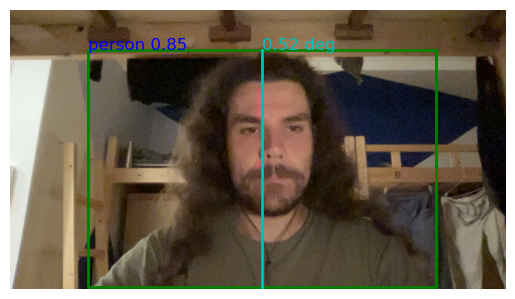

 0.10 deg


In [14]:
yolo_model = YOLO('yolov8s.pt')

try:
    # Initiate the camera
    prev_angle = 0.0
    vid = cv2.VideoCapture(0)
    time.sleep(0.5)

    while True:
        frame = grab_frame(vid)
        res = yolo_model(frame, verbose=False)
        objs = get_objs(res)

        clear_output(wait=True)

        fig, ax = plt.subplots()
        ax.imshow(frame)

        for index, obj in objs.iterrows():
            if obj['class'] != 0: continue
            if obj['score'] < 0.4: continue
            on_edge = obj['xmin'] < 10 or obj['xmax'] > wr - 10
            color = 'r' if on_edge else 'g'

            rect = patches.Rectangle((obj['xmin'], obj['ymin']), obj['xmax'] - obj['xmin'], obj['ymax'] - obj['ymin'], linewidth=2, edgecolor=color, facecolor='none')
            ax.add_patch(rect)
            text = f'{obj["name"]} {obj["score"]:.2f}'
            ax.text(obj['xmin'], obj['ymin'], text, color='b', fontsize=12)

            # draw vertical line at xcenter
            center_df = obj['xcenter']
            if on_edge:
                center_df = obj['xcenter'] // 2 if center_df < wr / 2 else (center_df + wr) // 2
            # angle_deg = (center - wr / 2) * hfov / wr
            angle_deg = pixel_angle(hfov, wr, center_df)
            ax.plot([center_df, center_df], [obj['ymin'], obj['ymax']], color='c', linewidth=2)
            ax.text(center_df, obj['ymin'], f'{angle_deg:.2f} deg', color='c', fontsize=12)

            mov_angle = angle_deg - prev_angle
            prev_angle = angle_deg

        plt.axis('off')
        plt.show()
        print(f' {mov_angle:.2f} deg')

        # save angle to csv with pandas - angle_deg and mov_angle
        # todo need to isolate one person only
        # todo add new on firts line
        pd.DataFrame({
            'a': [round(angle_deg, 2)],
            'da': [round(mov_angle, 2)]
        }).to_csv('var.csv', index=False, mode='a', header=False)
        
        # Frame rate
        plt.pause(0.15)
        # break

except KeyboardInterrupt:
    vid.release()  # Release the camera resource

vid.release()  # Release the camera resource if break

In [47]:
def get_torso_properties(results, frame):
    left_shoulder = results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_SHOULDER]
    right_shoulder = results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_SHOULDER]
    left_hip = results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_HIP]
    right_hip = results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_HIP]

    left_shoulder_point = landmark_point(left_shoulder, frame.shape[1], frame.shape[0])
    right_shoulder_point = landmark_point(right_shoulder, frame.shape[1], frame.shape[0])
    left_hip_point = landmark_point(left_hip, frame.shape[1], frame.shape[0])
    right_hip_point = landmark_point(right_hip, frame.shape[1], frame.shape[0])

    shoulder_point = left_shoulder_point.middle(right_shoulder_point)
    hip_point = left_hip_point.middle(right_hip_point)
    
    torso_pixel_height = shoulder_point.distance(hip_point)
    shoulder_pixel_width = left_shoulder_point.distance(right_shoulder_point)

    return torso_pixel_height, shoulder_pixel_width, shoulder_point, hip_point


yolo_model = YOLO('yolov8s.pt')


try:
    mp_pose = mp.solutions.pose
    pose = mp_pose.Pose(static_image_mode=False)

    # read video from file .mov file
    vid = cv2.VideoCapture('./Movie on 2023-11-23 at 10.03.mov')

    # read video from camera
    # vid = cv2.VideoCapture(1)

    distance_queue = queue.Queue(maxsize=3)

    while vid.isOpened():
        frame = grab_frame(vid)

        # skip 14 frames
        for i in range(14):
            vid.grab()

        # Frame rate
        # plt.pause(0.15)

        results = pose.process(frame)
        objs = get_objs(yolo_model(frame, verbose=False))

        if results.pose_landmarks is not None:
            mp_drawing = mp.solutions.drawing_utils
            mp_drawing.draw_landmarks(frame, results.pose_landmarks, mp_pose.POSE_CONNECTIONS)

            torso_pixel_height, shoulder_pixel_width, shoulder_point, hip_point = get_torso_properties(results, frame)
            middle_point = shoulder_point.middle(hip_point)

            angle = pixel_angle(hfov, wr, middle_point.x)
            # distance = distance_to_camera(hfov, wr, angle, avg_shoulder_width, shoulder_pixel_width)
            distance = distance_to_camera(hfov, wr, angle, avg_torso_height, torso_pixel_height)

            angle = round(angle, 1)
            distance = int(distance // 10 * 10)

            if distance_queue.full():
                distance_queue.get()
            distance_queue.put(distance)

            sorted_queue = sorted(distance_queue.queue)
            index = round(len(sorted_queue) / 2)
            if distance_queue.full():
                # distance = np.mean(sorted_queue[index - 1:index + 1])
                distance = distance_queue.queue[index]
            else:
                distance = sorted_queue[round(len(sorted_queue) / 2)]
                distance = distance_queue.queue[-1]

            distance = int(distance // 10 * 10)

            print(f'{distance} mm')
            print(f'{angle} deg')

        clear_output(wait=True)
        fig, ax = plt.subplots()
        ax.imshow(frame)
        if results.pose_landmarks is not None:
            ax.scatter(shoulder_point.x, shoulder_point.y, c='r', s=10)
            ax.scatter(hip_point.x, hip_point.y, c='r', s=10)
            ax.plot([middle_point.x, middle_point.x], [0, frame.shape[0]], color='c', linewidth=2)
        plt.axis('off')
        plt.show()

        pd.DataFrame({
            't': [round(time.time(), 3)],
            'a': [angle],
            'd': [distance]
        }).to_csv('var.csv', index=False, mode='a', header=False)


except KeyboardInterrupt:
    vid.release()  # Release the camera resource

vid.release()  # Release the camera resource if break


I0000 00:00:1700829977.628225       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1
[ WARN:0@27972.759] global /private/var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_11nitadzeg/croot/opencv-suite_1691620374638/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created


error: OpenCV(4.6.0) /private/var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_11nitadzeg/croot/opencv-suite_1691620374638/work/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


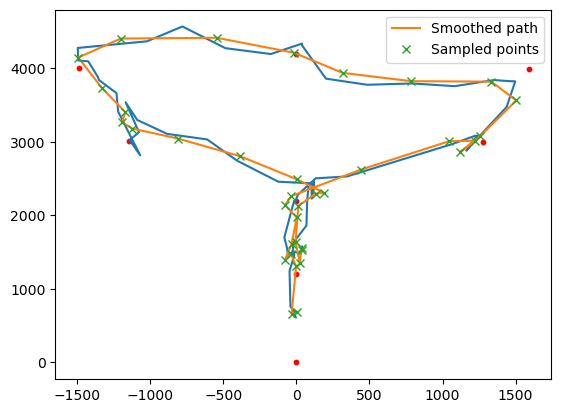

In [80]:
from scipy import interpolate
from scipy.interpolate import splrep, BSpline, splprep

# read csv
df = pd.read_csv('var_2fps.csv')
df.columns = ['t', 'a', 'd'] # time angle distance

# add column x and y
df['x'] = df['d'] * 1.15 * np.cos(np.radians(df['a']))
df['y'] = df['d'] * 1.15 * np.sin(np.radians(df['a']))



# fig, ax = plt.subplots()
# ax.plot(df['y'], df['x'])
# for p in points:
#     ax.scatter(p.y, p.x, c='r', s=10)
# plt.show()


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.interpolate import LSQUnivariateSpline

# Assuming df is your DataFrame with 'x' and 'y' columns
# df = pd.read_csv('your_data.csv')  # Uncomment this line if you need to load data from a CSV file

ti = df.index

# Set the number of knots. Adjust this according to your data
# num_knots = 10
num_knots = int((ti.max() - ti.min()) // 4)
t_knots = np.linspace(ti.min(), ti.max(), num_knots)[1:-1]  # Exclude first and last points

# Fit the spline for 'x' and 'y' coordinates
spline_x = LSQUnivariateSpline(ti, df['x'], t_knots)
spline_y = LSQUnivariateSpline(ti, df['y'], t_knots)

num_samples = num_knots * 2
t_smooth = np.linspace(ti.min(), ti.max(), num_samples)

# Evaluate the spline at these points
x_sampled = spline_x(t_smooth)
y_sampled = spline_y(t_smooth)

# Create a DataFrame with the sampled data
sampled_df = pd.DataFrame({
    't': t_smooth,
    'x': x_sampled,
    'y': y_sampled
})

fig, ax = plt.subplots()
ax.plot(df['y'], df['x'])
for p in ref_points:
    ax.scatter(p.y, p.x, c='r', s=10)
ax.plot(spline_y(t_smooth), spline_x(t_smooth), label='Smoothed path')
# ax.plot(spline_y(t_smooth), spline_x(t_smooth))
ax.plot(spline_y(t_smooth), spline_x(t_smooth), 'x', label='Sampled points')
ax.legend()
plt.show()


# x = spline_x(t_smooth)
# y = spline_y(t_smooth)



# for i in range(len(x) - 4):
#     # angle between i-1 and i
#     if i == 0:
#         p1 = Point(0, 0)
#     else:
#         p1 = Point(x[i-1], y[i-1])
#     p2 = Point(x[i], y[i])

#     angle = p1.angle(p2)

#     # list of 4 points with list comprehension
#     px = [Point(x[i], y[i]) for i in range(i, i+4)]

#     # rotate 4 points by -angle around p2
#     px = [p.rotate_df(-angle, p2) for p in px]

#     clear_output(wait=True)
#     fig, ax = plt.subplots()
#     px_x = [p.x for p in px]
#     px_y = [p.y for p in px]
#     ax.plot(px_y, px_x)
    
#     ax.legend()
#     plt.show()
#     plt.pause(0.5)




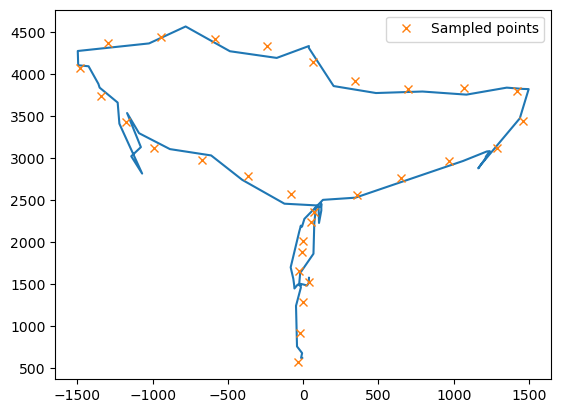

In [36]:
import numpy as np
import pandas as pd
from scipy.interpolate import LSQUnivariateSpline
import matplotlib.pyplot as plt


df = pd.read_csv('var_2fps.csv')
df.columns = ['t', 'a', 'd']
df['x'] = df['d'] * 1.15 * np.cos(np.radians(df['a']))
df['y'] = df['d'] * 1.15 * np.sin(np.radians(df['a']))

ti = np.array(df.index, dtype=float)
df['t'] = df['t'].astype(float)

# Define the spline
num_knots = int((ti.max() - ti.min()) // 4)
t_knots = np.linspace(ti.min(), ti.max(), num_knots)[1:-1]  # Exclude first and last points
spline_x = LSQUnivariateSpline(ti, df['x'], t_knots)
spline_y = LSQUnivariateSpline(ti, df['y'], t_knots)

# Initialize variables for sampling
min_distance = 350
sampled_points = []
last_point = None

# Iterate over the spline
for ti in np.linspace(ti.min(), ti.max(), 1000):  # Adjust the number of points as necessary
    current_point = Point(spline_x(ti), spline_y(ti), 0)  # Assuming z=0 as it's not in the DataFrame

    if last_point is None:
        # First point
        sampled_points.append(current_point)
        last_point = current_point
    else:
        # Check distance
        if current_point.distance(last_point) >= min_distance:
            sampled_points.append(current_point)
            last_point = current_point

# Convert sampled points to a DataFrame
sampled_df = pd.DataFrame([(p.x, p.y) for p in sampled_points], columns=['x', 'y'])


# spline_timestamp = LSQUnivariateSpline(ti, df['t'], t_knots)
# sampled_timestamps = spline_timestamp([p.t for p in sampled_points])
# sampled_df['timestamp'] = sampled_timestamps


# sampled_df['dd'] = 0
# for i in range(1, len(sampled_df['x'])):
#     p1 = Point(sampled_df['x'][i-1], sampled_df['y'][i-1], 0)
#     p2 = Point(sampled_df['x'][i], sampled_df['y'][i], 0)
#     sampled_df['dd'][i] = p1.distance(p2)


# # add column td which is the sum of the previous td and its dd
# sampled_df['td'] = 0
# for i in range(1, len(sampled_df['x'])):
#     p1 = Point(sampled_df['x'][i-1], sampled_df['y'][i-1], 0)
#     p2 = Point(sampled_df['x'][i], sampled_df['y'][i], 0)
#     sampled_df['td'][i] = sampled_df['td'][i-1] + p1.distance(p2)


# # print the whole values of sampled_df['timestamp']
# for i in range(len(sampled_df['timestamp'])):
#     print(sampled_df['timestamp'][i])


# Plot to verify
fig, ax = plt.subplots()
ax.plot(df['y'], df['x'])
ax.plot([p.y for p in sampled_points], [p.x for p in sampled_points], 'x', label='Sampled points')
# ax.plot([p.y for p in sampled_points], [p.x for p in sampled_points])
ax.legend()
plt.show()

# save to csv
# convert to int
sampled_df['x'] = sampled_df['x'].astype(int)
sampled_df['y'] = sampled_df['y'].astype(int)
# sampled_df.to_csv('sampled_positions.csv', index=False, header=False)

# sampled_df now contains the sampled data points


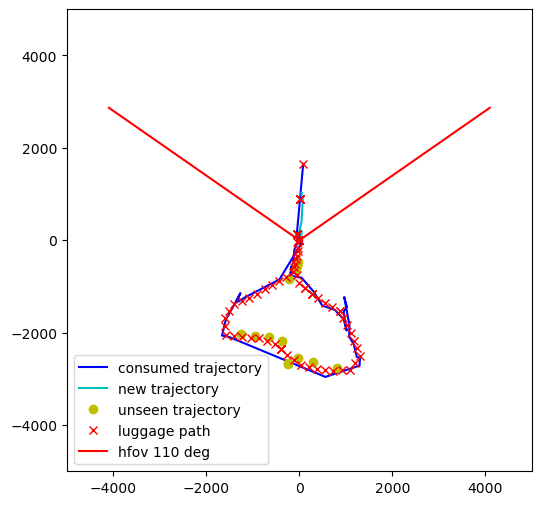

In [79]:
import pandas as pd
from scipy.interpolate import LSQUnivariateSpline
import matplotlib.pyplot as plt


marching_rate = 0.5
position = 0
index = 0
ratio = 0.0

def move(position, marching_rate):
    position += marching_rate
    index = int(position)
    return position, index, position - index


def consume(seen_s, rotated):
    # luggage position is 0,0
    for i in range(1, len(seen_s)):
        previous = seen_s.iloc[i-1]
        current = rotated.iloc[i]
        if previous['c'] == 1 and current['x'] <= 0:
            seen_s['c'][i] = 1


# def get_s_data(s_data, index):
#     if index >= len(s_data):
#         return s_data.iloc[-1]
#     return s_data.iloc[index]


def get_s_data(s_data, seen_s, l_p, angle, index):
    last_seen = seen_s.iloc[-1]
    if index >= len(s_data):
        return last_seen, 0
    
    origin = Point.origin()
    new_pt = s_data.iloc[index]
    pt = Point(new_pt['x'], new_pt['y'])
    pt = l_p.rotate(angle, pt)
    angle = origin.angle(pt)
    if abs(angle) > 55:
        return last_seen, angle
    return new_pt, 0


# sensor data
s_data = pd.read_csv('dist_2fps.csv', header=None)
s_data.columns = ['t', 'x', 'y']

# luggage data
l_data = pd.read_csv('sampled_positions.csv', header=None)
l_data.columns = ['x', 'y']

# luggage path
l_path = pd.DataFrame(columns=['x', 'y'])

# dataframe to store the seen points time, x, y, consumed
seen_s = pd.DataFrame(columns=['t', 'x', 'y', 'c'])
seen_s = pd.concat([seen_s, pd.DataFrame({
    't': 0,
    'x': 0,
    'y': 0,
    'c': True
}, index=[len(seen_s)])])

unseen_s = pd.DataFrame(columns=['t', 'x', 'y'])


# image each loop is 0.5 second
for i in range(len(s_data['x']) + 10):
    clear_output(wait=True)

    # current luggage position
    l1 = Point(l_data.iloc[index]['x'], l_data.iloc[index]['y'])
    l2 = Point(l_data.iloc[index + 1]['x'], l_data.iloc[index + 1]['y'])
    luggage_position = l1.between(l2, ratio)
    l_path = pd.concat([l_path, pd.DataFrame({
        'x': [luggage_position.x],
        'y': [luggage_position.y]
    }, index=[len(l_path)])])
    angle = l1.angle(l2)

    # get sensor data
    new_pt, is_out = get_s_data(s_data, seen_s, luggage_position, angle, i)
    pt = Point(new_pt['x'], new_pt['y'])
    seen_s = pd.concat([seen_s, pd.DataFrame({
        't': [new_pt['t']],
        'x': [new_pt['x']],
        'y': [new_pt['y']], 
        'c': 0
    }, index=[len(seen_s)])])

    if is_out:
        unseen_pt = s_data.iloc[i]
        unseen_s = pd.concat([unseen_s, pd.DataFrame({
            't': [unseen_pt['t']],
            'x': [unseen_pt['x']],
            'y': [unseen_pt['y']], 
        }, index=[len(unseen_s)])])

    # transform
    rot_unseen = luggage_position.rotate_df(angle, unseen_s)
    rotated = luggage_position.rotate_df(angle, seen_s)
    path_rot = luggage_position.rotate_df(angle, l_path)
    luggage_position = Point.origin()

    # consume trajectory
    consume(seen_s, rotated)
    rotated['c'] = seen_s['c']
    
    # plot
    fig, ax = plt.subplots()
    ax.set_ylim([-5000, 5000])
    ax.set_xlim([-5000, 5000])
    fig.set_figheight(6)
    fig.set_figwidth(6)

    # plot trajectory
    rot_consume = rotated[rotated['c'] == True]
    rot_not_consume = rotated[rotated['c'] == False]
    rot_not_consume = pd.concat([rot_consume.iloc[-1], rot_not_consume])

    ax.plot(rot_consume['y'], rot_consume['x'], color='b', label='consumed trajectory')
    ax.plot(rot_not_consume['y'], rot_not_consume['x'], color='c', label='new trajectory')
    ax.plot(rot_unseen['y'], rot_unseen['x'], 'o', color='y', label='unseen trajectory')

    # plot luggage position
    ax.plot(path_rot['y'], path_rot['x'], 'x', color='r', label='luggage path')
    ax.scatter(luggage_position.y, luggage_position.x, c='r', s=20)

    # draw two lines from origin to 55 degree and -55 degree
    p1 = Point.origin()
    p2 = Point(5000, 0)
    p3 = Point(5000, 0)
    p2 = p1.rotate(55, p2)
    p3 = p1.rotate(-55, p3)
    ax.plot([p1.y, p2.y], [p1.x, p2.x], color='r', label='hfov 110 deg')
    ax.plot([p1.y, p3.y], [p1.x, p3.x], color='r')

    ax.legend()
    plt.show()
    plt.pause(0.1)

    # move luggage to next point
    pt = rotated.iloc[-1]
    pt = Point(pt['x'], pt['y'])
    distance = pt.distance(Point.origin())
    angle = (pt.angle(Point.origin()) + 180) % 360
    if is_out or distance > 1500 or (distance > 1000 and abs(angle) > 40):
        position, index, ratio = move(position, marching_rate)


